In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import pandas as pd
import plotly.graph_objects as go

from scipy.stats import norm, poisson

import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression

In [2]:
path_figures ='FIGURES/'
path_tables ='TABLES/'
#df_val4 = pd.read_csv(path_tables+'val_app4.csv')
df_val5 = pd.read_csv(path_tables+'val_app6_gau.csv')

In [3]:
display(df_val5.shape)
display(df_val5.head())
df_val5.columns

(4760, 699)

N_H_Z  N_H_S  Gamma    A_S  N_H_Z_pred  N_H_S_pred  Gamma_pred   A_S_pred  \
0  1.494  0.255   1.56   0.49    1.097034    0.186202    1.612870   0.287882   
1  0.681  0.173   1.78   0.80    0.666894    0.206920    1.807400   0.607143   
2  0.057  0.385   1.74  11.54    0.060874    0.328431    1.752109  10.524874   
3  2.190  0.227   1.65   0.11    1.956719    0.212026    1.704102   0.404386   
4  0.736  0.190   2.17   0.11    0.634536    0.278436    1.961299   0.576721   

   within_68  N_H_Z_int68  ...        703       704  705       706       707  \
0      False     0.255534  ...   0.000000  25.00062  0.0  75.00186  74.99828   
1       True     0.186970  ...  49.998856   0.00000  0.0  25.00062   0.00000   
2      False     0.052133  ...   0.000000  25.00062  0.0  25.00062   0.00000   
3      False     0.969956  ...   0.000000   0.00000  0.0   0.00000   0.00000   
4      False     0.300274  ...  24.999428   0.00000  0.0  25.00062   0.00000   

        708  709  DOUBLE_EXP_TIME_(s)       z          nH_G  
0   0.00000  0.0             43954.49  0.0377  5.093854e+20  
1  25.00062  0.0             47139.48  0.0584  3.747554e+20  
2   0.00000  0.0             30988.60  0.0435  1.533225e+21  
3   0.00000  0.0             28176.10  0.0216  5.902024e+20  
4   0.00000  0.0             29324.64  0.0240  7.740000e+19  

[5 rows x 699 columns]

Index(['N_H_Z', 'N_H_S', 'Gamma', 'A_S', 'N_H_Z_pred', 'N_H_S_pred',
       'Gamma_pred', 'A_S_pred', 'within_68', 'N_H_Z_int68',
       ...
       '703', '704', '705', '706', '707', '708', '709', 'DOUBLE_EXP_TIME_(s)',
       'z', 'nH_G'],
      dtype='object', length=699)

In [4]:
#set(df_val5['Gamma_pred'].values)

In [5]:
# Función para redondear a n cifras significativas
def round_sig(x, sig=3):
    if pd.isnull(x):
        return x
    return round(x, sig - int(np.floor(np.log10(abs(x)))) - 1) if x != 0 else 0

# Aplicar redondeo
df_val5['N_H_Z_pred'] = df_val5['N_H_Z_pred'].apply(lambda x: round_sig(x, 3))
df_val5['N_H_S_pred'] = df_val5['N_H_S_pred'].apply(lambda x: round_sig(x, 3))
df_val5['Gamma_pred'] = df_val5['Gamma_pred'].apply(lambda x: round_sig(x, 2))
df_val5['A_S_pred'] = df_val5['A_S_pred'].apply(lambda x: round_sig(x, 2))


In [6]:
set(df_val5['Gamma_pred'].values)

{np.float64(1.4),
 np.float64(1.5),
 np.float64(1.6),
 np.float64(1.7),
 np.float64(1.8),
 np.float64(1.9),
 np.float64(2.0),
 np.float64(2.1)}

In [7]:
'''Columns correspont to range 8 to 15 KeV.
'''

folder_path = 'TABLES/mytd_gaussian/'

# List all .txt files in the folder, 
#endswith: this fuction to verifica if a str finishes in a subfix
all_filenames = [f for f in os.listdir(folder_path) if f.endswith(".txt")]

energy = pd.read_csv(folder_path+'/'+all_filenames[1], names=['energy', 'counts'], header=None, sep="\s+")
energy_range = energy[((energy['energy']>=3) & (energy['energy']<30))]
energy = pd.DataFrame(energy['energy']).T

signal = energy.loc[:, (energy.iloc[0]>=8) & (energy.iloc[0]<=15)]
signal_col = signal.columns.values

In [8]:
'''We define the relative error for each physical parameter:
    'N_H_Z', 'N_H_S', 'Gamma', 'A_S'.
    gap.append(abs(theta_true_original - modas_aproximadas))
'''

relative_error_columns = ['N_H_Z_re', 'N_H_S_re', 'Gamma_re', 'A_S_re']
pred_parameters = ['N_H_Z_pred', 'N_H_S_pred', 'Gamma_pred', 'A_S_pred']
fake_parameters = ['N_H_Z', 'N_H_S', 'Gamma', 'A_S']

# se hace un for para evitar errores de eleccion de columna
for pred_col, true_col, out_col in zip(pred_parameters, fake_parameters, relative_error_columns):
    df_val5[out_col] = (df_val5[pred_col] - df_val5[true_col] )/ df_val5[true_col]

spectra = df_val5.columns[160:335]
mu = df_val5[spectra].mean(axis=1)
std = df_val5[spectra].std(axis=1)
sn = mu / std
df_val5['S/N'] = sn.values
SN_class = df_val5['S/N'] >= 1.2
df_val5['SN_class'] = SN_class

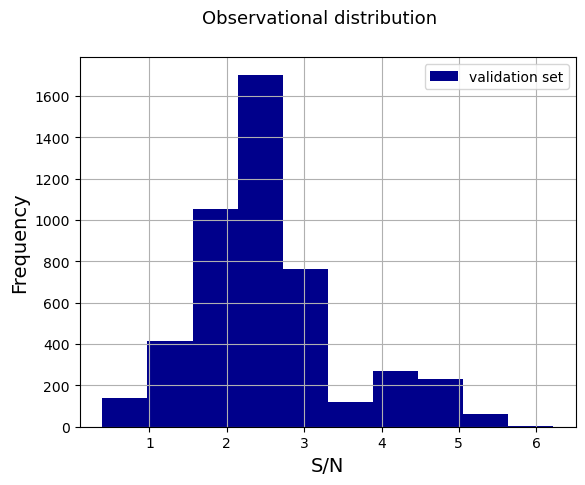

In [12]:
df_val5['S/N'].hist(color='darkblue', label='validation set')
plt.xlabel('S/N', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

plt.legend()
plt.suptitle("Observational distribution", fontsize=13)
plt.savefig('FIGURES/' + f"hist_sn_Gau.pdf",
            bbox_inches="tight")

In [10]:
df_val5['S/N'].describe()

count    4760.000000
mean        2.525120
std         0.940887
min         0.390524
25%         1.924635
50%         2.420294
75%         2.851398
max         6.219930
Name: S/N, dtype: float64

In [11]:
counts = np.arange(35, 710)
print(len(counts))
str_counts = [str(elemento) for elemento in counts]

target = df_val5[fake_parameters].copy()
spectra_columns = df_val5[str_counts].copy()

display(target.shape)
display(spectra_columns.shape)

675


(4760, 4)

(4760, 675)

In [12]:
def edges_from_keV(E, cuts_keV):
    """
    E: array de energías (keV), debe ser creciente
    cuts_keV: lista de límites en keV, p.ej. [3,6,10,20,35,50]
    devuelve edges_idx (índices) para usar con windowed_features / graficado
    """
    E = np.asarray(E)
    if not np.all(np.diff(E) > 0):
        raise ValueError("E debe ser estrictamente creciente. Ordena E (y X) primero.")
    # Busca en el array E en qué posición se deberían insertar los valores de cuts_keV para que E se mantenga ordenado
    idx = np.searchsorted(E, cuts_keV, side='left')
    # todo los valores de idx los lleva a el rango 0 y la longitud del vector energia
    idx = np.clip(idx, 0, len(E))
    # Asegura 0 y n_bins como extremos
    if idx[0] != 0:
        idx = np.r_[0, idx]
    if idx[-1] != len(E):
        idx = np.r_[idx, len(E)]
    # Elimina duplicados por bins vacíos (si un corte cae en el mismo bin)
    idx = np.unique(idx)
    return idx.tolist()

def windowed_features(X, edges):
    '''Windows for study the correlation among
    the physical parameters and the energy distribution regions
    # zip(edges[:-1], edges[1:])
    edges es una lista/array de cortes (por ejemplo, bordes de bins en energía).

    edges[:-1] → todos los elementos menos el último.

    edges[1:] → todos los elementos menos el primero.

    zip(...) → forma pares (a, b) con cada borde inicial y final consecutivo.

    # for a, b in ... if b > a
    Itera sobre cada par (a, b) pero solo si el índice final b es mayor que el inicial a (evita ventanas vacías o invertidas).

    # X[:, a:b].mean(axis=1)
    X[:, a:b] selecciona todas las filas (:) y las columnas desde a hasta b-1.
    .mean(axis=1) calcula el promedio por fila dentro de ese rango de columnas.
    Esto genera un vector (una nueva feature) para esa ventana.

    # feats = [ ... ]
    Crea una lista donde cada elemento es ese vector de promedios para una ventana distinta.

    # np.column_stack(feats) lo que hace es tomar varias secuencias o arrays 1D y apilarlos como columnas para formar una sola matriz 2D.
    Es decir:
    Cada elemento de la lista feats se convierte en una columna.
    El número de filas de la matriz resultante será igual a la longitud de cada array en feats.
    '''
    feats = [X[:, a:b].mean(axis=1) for a,b in zip(edges[:-1], edges[1:]) if b>a]
    
    return np.column_stack(feats) if feats else np.empty((X.shape[0], 0))


In [13]:
# --- Datos --- y eleccion de numero de regions
X = spectra_columns.values            # (n_spec, n_bins)
Y = target.values                     # (n_spec,)  o  (n_spec, n_params)
n_bins = X.shape[1]

# Ejemplo: define cortes en keV
cuts_keV = [3, 8, 13, 18, 23, 28, 30]   # => 7 regiones
E = energy_range['energy'].values
# Ordena E y X si hiciera falta
#if not np.all(np.diff(E) > 0):
#    order = np.argsort(E); E = E[order]; X = X[:, order]

edges = edges_from_keV(E, cuts_keV)     # índices desde keV
Xw = windowed_features(X, edges)        # recalcula features por ventana

print(len(edges))
print(Xw.shape)

# Máscara de valores finitos para que no salte problema con MI 
mask_X = np.isfinite(Xw).all(axis=1)
mask_Y = np.isfinite(Y).all(axis=1) if Y.ndim == 2 else np.isfinite(Y)
mask = mask_X & mask_Y
Xw_ok, Y_ok = Xw[mask], Y[mask]

7
(4760, 6)


In [14]:
# --- Calcular MI para un parámetro ---
# --- ['N_H_Z', 'N_H_S', 'Gamma', 'A_S']
if Y_ok.ndim == 1:
    y_vec = Y_ok
    subtitle = ""
else:
    # por defecto, primer parámetro
    y_vec = Y_ok[:, 0]

mi_w_nhz = mutual_info_regression(Xw_ok, y_vec, n_neighbors=5, random_state=0)

In [15]:
# --- ['N_H_Z', 'N_H_S', 'Gamma', 'A_S']
if Y_ok.ndim == 1:
    y_vec = Y_ok
    subtitle = ""
else:
    # por defecto, primer parámetro
    y_vec = Y_ok[:, 1]

mi_w_nhs = mutual_info_regression(Xw_ok, y_vec, n_neighbors=5, random_state=0)

In [16]:
# --- Calcular MI para un parámetro ---
# --- ['N_H_Z', 'N_H_S', 'Gamma', 'A_S']
if Y_ok.ndim == 1:
    y_vec = Y_ok
    subtitle = ""
else:
    # por defecto, primer parámetro
    y_vec = Y_ok[:, 2]

mi_w_gamma = mutual_info_regression(Xw_ok, y_vec, n_neighbors=5, random_state=0)

In [17]:
# --- Calcular MI para un parámetro ---
# --- ['N_H_Z', 'N_H_S', 'Gamma', 'A_S']
if Y_ok.ndim == 1:
    y_vec = Y_ok
    subtitle = ""
else:
    # por defecto, primer parámetro
    y_vec = Y_ok[:, 3]

mi_w_as = mutual_info_regression(Xw_ok, y_vec, n_neighbors=5, random_state=0)

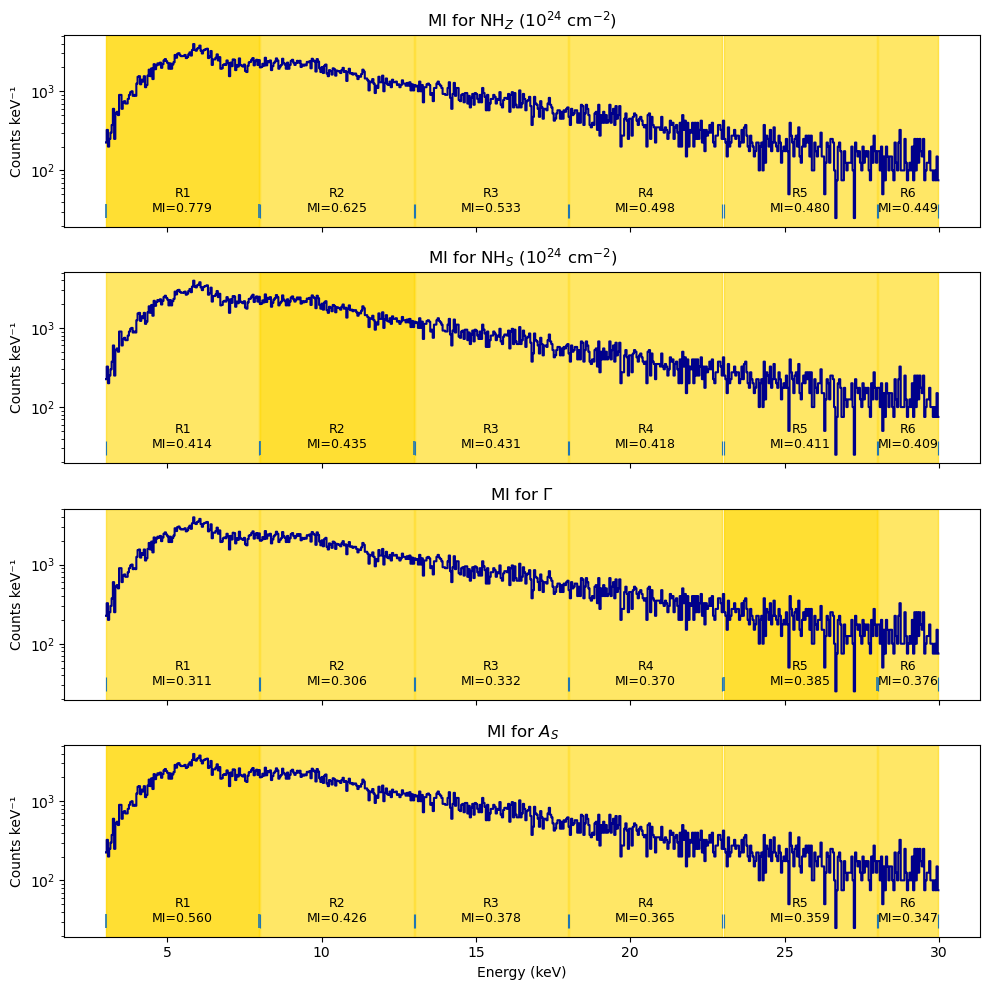

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Asumo que existen: E, edges, energy_range, mi_w_nhz, mi_w_nhs, mi_w_gamma, mi_w_as
x = E

subtitle_nhz   = "MI for " + r"NH$_{Z}\ (10^{24}\ \mathrm{cm}^{-2})$"
subtitle_nhs   = "MI for " + r"NH$_{S}\ (10^{24}\ \mathrm{cm}^{-2})$"
subtitle_gamma = "MI for " + r"$\Gamma$"
subtitle_as    = "MI for " + r"$A_{S}$"

panels = [
    (mi_w_nhz,   subtitle_nhz),
    (mi_w_nhs,   subtitle_nhs),
    (mi_w_gamma, subtitle_gamma),
    (mi_w_as,    subtitle_as),
]

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 10), sharex=True)
axes = np.atleast_1d(axes)

ymin_counts = np.nanmin(energy_range['counts'].values)
y_text = ymin_counts * 1.1  # ajustá si querés el texto más arriba/abajo

for ax, (mi_w, title) in zip(axes, panels):
    mi_w = np.asarray(mi_w, dtype=float) if mi_w is not None else None

    # Espectro
    ax.step(energy_range['energy'], energy_range['counts'], where='mid', color='darkblue', lw=1.5)

    # Máscara de regiones máximas dentro de este panel (soporta empates)
    if mi_w is not None and mi_w.size > 0 and np.isfinite(mi_w).any():
        mi_max = np.nanmax(mi_w)
        is_max = np.isclose(mi_w, mi_max, equal_nan=False)
    else:
        is_max = None  # no resalta nada si no hay MI válido

    for k, (a, b) in enumerate(zip(edges[:-1], edges[1:]), start=1):
        if b <= a:
            continue
        xa = x[a]
        xb = x[min(b-1, len(x)-1)]

        label = f"R{k}"
        if mi_w is not None and len(mi_w) >= k and np.isfinite(mi_w[k-1]):
            label += f"\nMI={mi_w[k-1]:.3f}"

        # si esta región es máxima dentro de este panel, usar color/alpha más fuerte
        if is_max is not None and k-1 < len(is_max) and is_max[k-1]:
            alpha_val = 0.8
            color_val = 'gold'
            lw_box = 1.2
        else:
            alpha_val = 0.6
            color_val = 'gold'
            lw_box = 0.8


        ax.axvspan(xa, xb, alpha=alpha_val, color=color_val)
        # contorno sutil para todas, un poco más marcado en las máximas
        ax.vlines([xa, xb], ymin_counts, ymin_counts*1.5, lw=lw_box)

        ax.text((xa+xb)/2, y_text, label, ha='center', va='bottom', fontsize=9)

    # Estética del panel
    ax.set_title(title)
    ax.set_ylabel('Counts keV⁻¹')
    ax.set_yscale('log')

# Ejes compartidos
axes[-1].set_xlabel('Energy (keV)')

plt.tight_layout()
plt.savefig(path_figures+'IM_Gau.png', format ='png',  bbox_inches='tight')

plt.show()


In [19]:
#df_val5[fake_parameters]
df_val5.columns

Index(['N_H_Z', 'N_H_S', 'Gamma', 'A_S', 'N_H_Z_pred', 'N_H_S_pred',
       'Gamma_pred', 'A_S_pred', 'within_68', 'N_H_Z_int68',
       ...
       '709', 'DOUBLE_EXP_TIME_(s)', 'z', 'nH_G', 'N_H_Z_re', 'N_H_S_re',
       'Gamma_re', 'A_S_re', 'S/N', 'SN_class'],
      dtype='object', length=705)

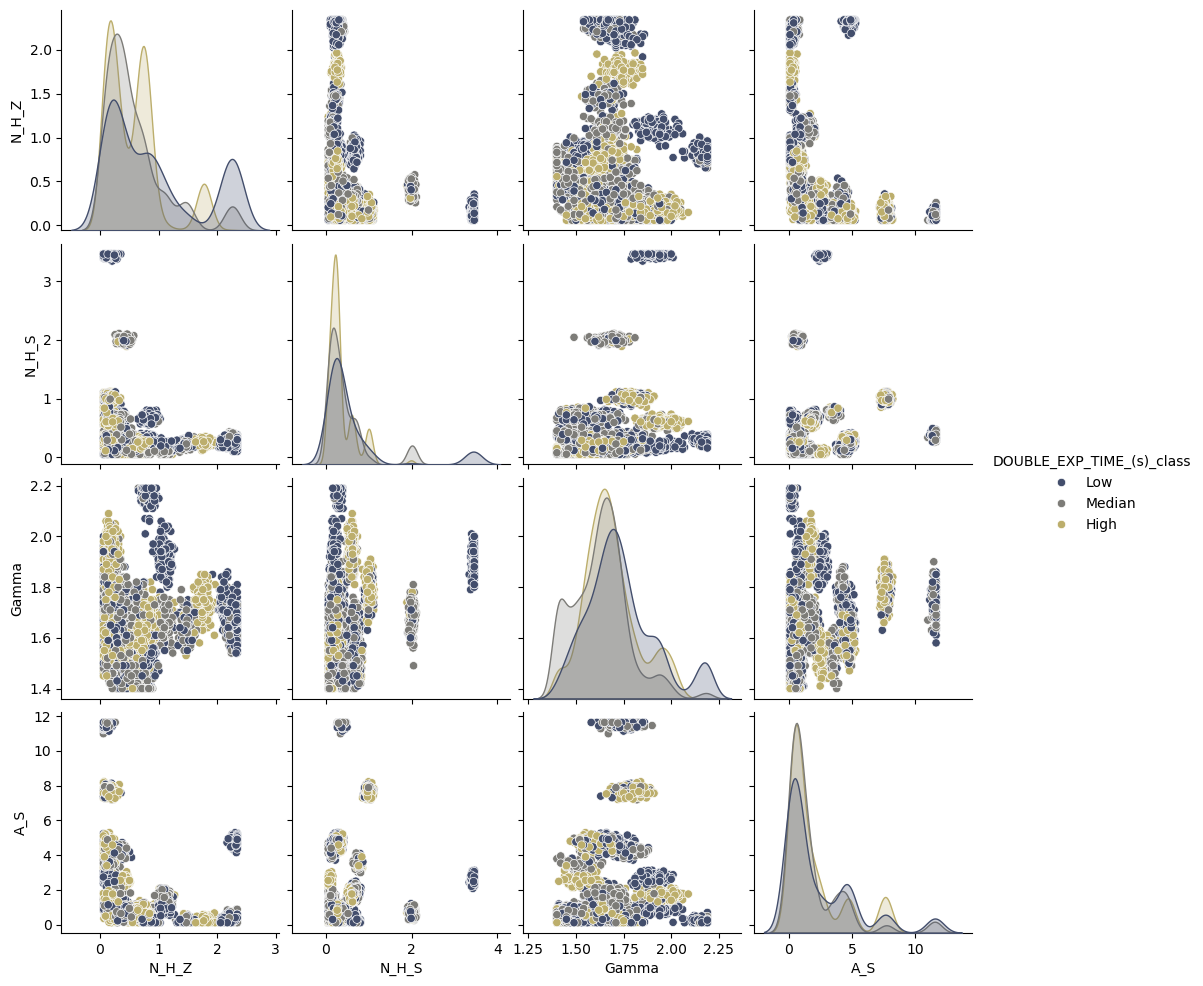

In [26]:
# Definir los límites de los bins
bins = [df_val5['DOUBLE_EXP_TIME_(s)'].min(), df_val5['DOUBLE_EXP_TIME_(s)'].quantile(1/3),
        df_val5['DOUBLE_EXP_TIME_(s)'].quantile(2/3), df_val5['DOUBLE_EXP_TIME_(s)'].max()]
labels = ['Low', 'Median', 'High']

# Crear la nueva columna de clasificación
df_val5['DOUBLE_EXP_TIME_(s)_class'] = pd.cut(df_val5['DOUBLE_EXP_TIME_(s)'], bins=bins, labels=labels, include_lowest=True)

# Crear el pairplot con colores según 'z_class'
sns.pairplot(df_val5, vars=['N_H_Z', 'N_H_S', 'Gamma', 'A_S'], 
             hue='DOUBLE_EXP_TIME_(s)_class',
             palette='cividis')
plt.savefig(path_figures+'parameters_per_DOUBLE_EXP_TIME_(s).png', format ='png',  bbox_inches='tight')
plt.show()

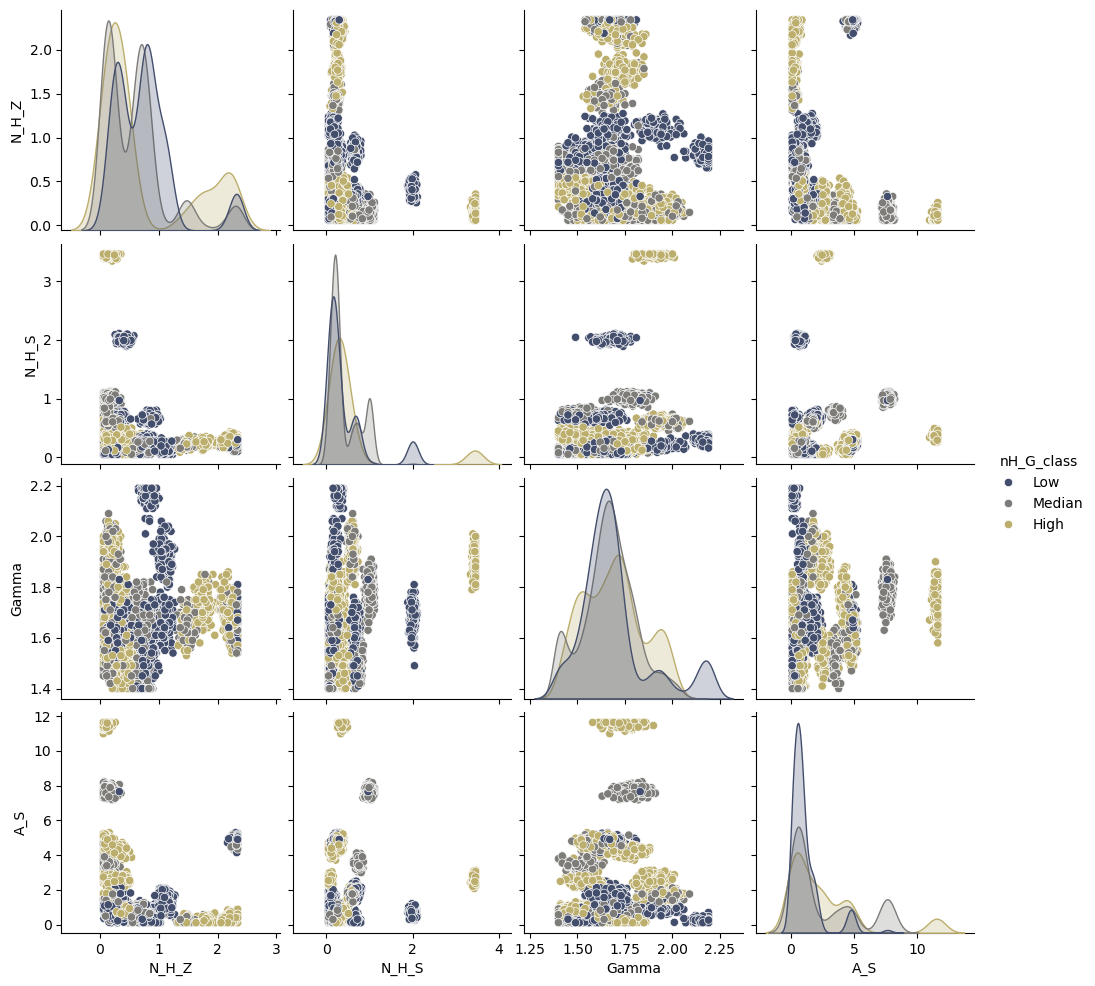

In [27]:
# Definir los límites de los bins
bins = [df_val5['nH_G'].min(), df_val5['nH_G'].quantile(1/3), df_val5['nH_G'].quantile(2/3), df_val5['nH_G'].max()]
labels = ['Low', 'Median', 'High']

# Crear la nueva columna de clasificación
df_val5['nH_G_class'] = pd.cut(df_val5['nH_G'], bins=bins, labels=labels, include_lowest=True)

# Crear el pairplot con colores según 'z_class'
sns.pairplot(df_val5, vars=['N_H_Z', 'N_H_S', 'Gamma', 'A_S'], hue='nH_G_class', palette='cividis')
plt.savefig(path_figures+'parameters_per_nH_G.png', format ='png',  bbox_inches='tight')
plt.show()

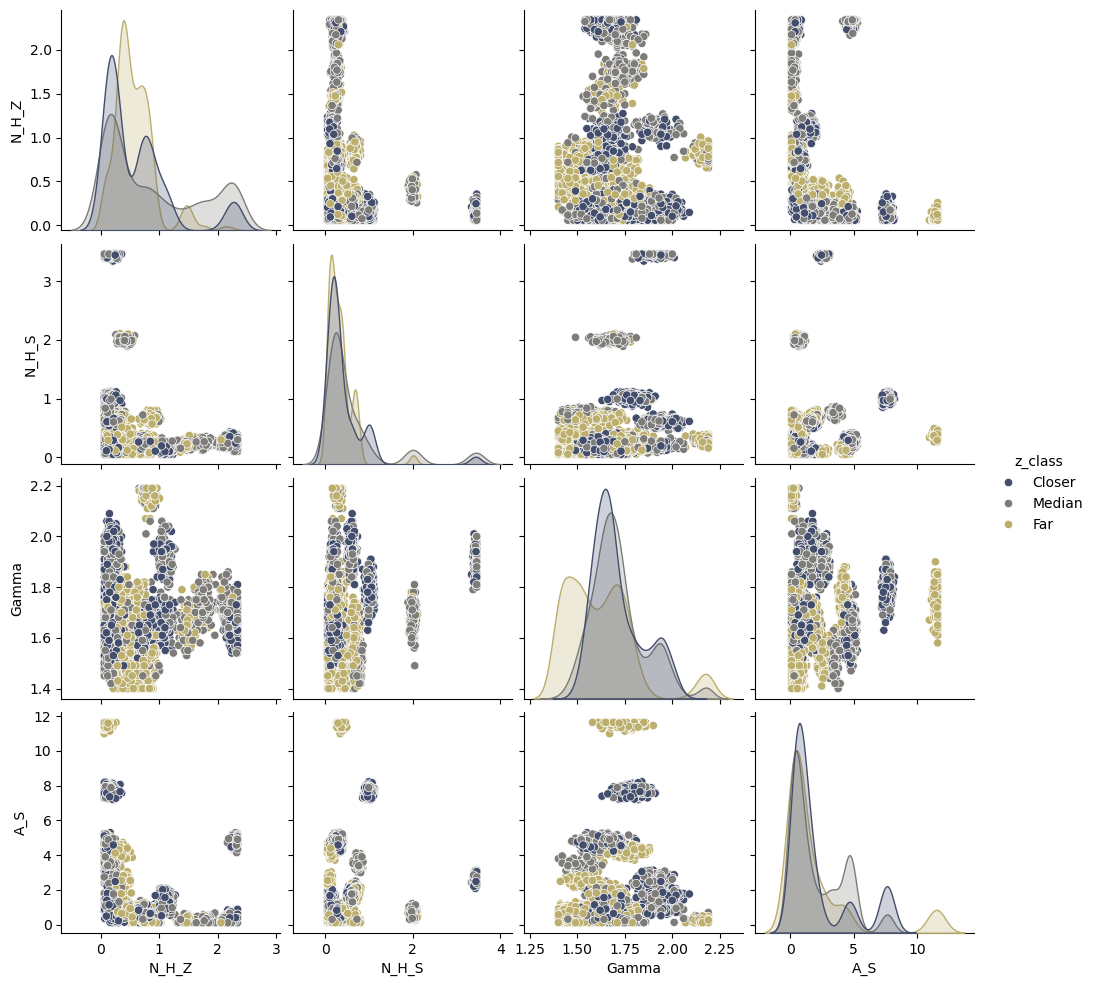

In [28]:
# Definir los límites de los bins
bins = [df_val5['z'].min(), df_val5['z'].quantile(1/3), df_val5['z'].quantile(2/3), df_val5['z'].max()]
labels = ['Closer', 'Median', 'Far']

# Crear la nueva columna de clasificación
df_val5['z_class'] = pd.cut(df_val5['z'], bins=bins, labels=labels, include_lowest=True)

# Crear el pairplot con colores según 'z_class'
sns.pairplot(df_val5, vars=['N_H_Z', 'N_H_S', 'Gamma', 'A_S'], hue='z_class', palette='cividis')
plt.savefig(path_figures+'parameters_per_z_class.png', format ='png',  bbox_inches='tight')
plt.show()

/tmp/ipykernel_85478/589464741.py:158: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


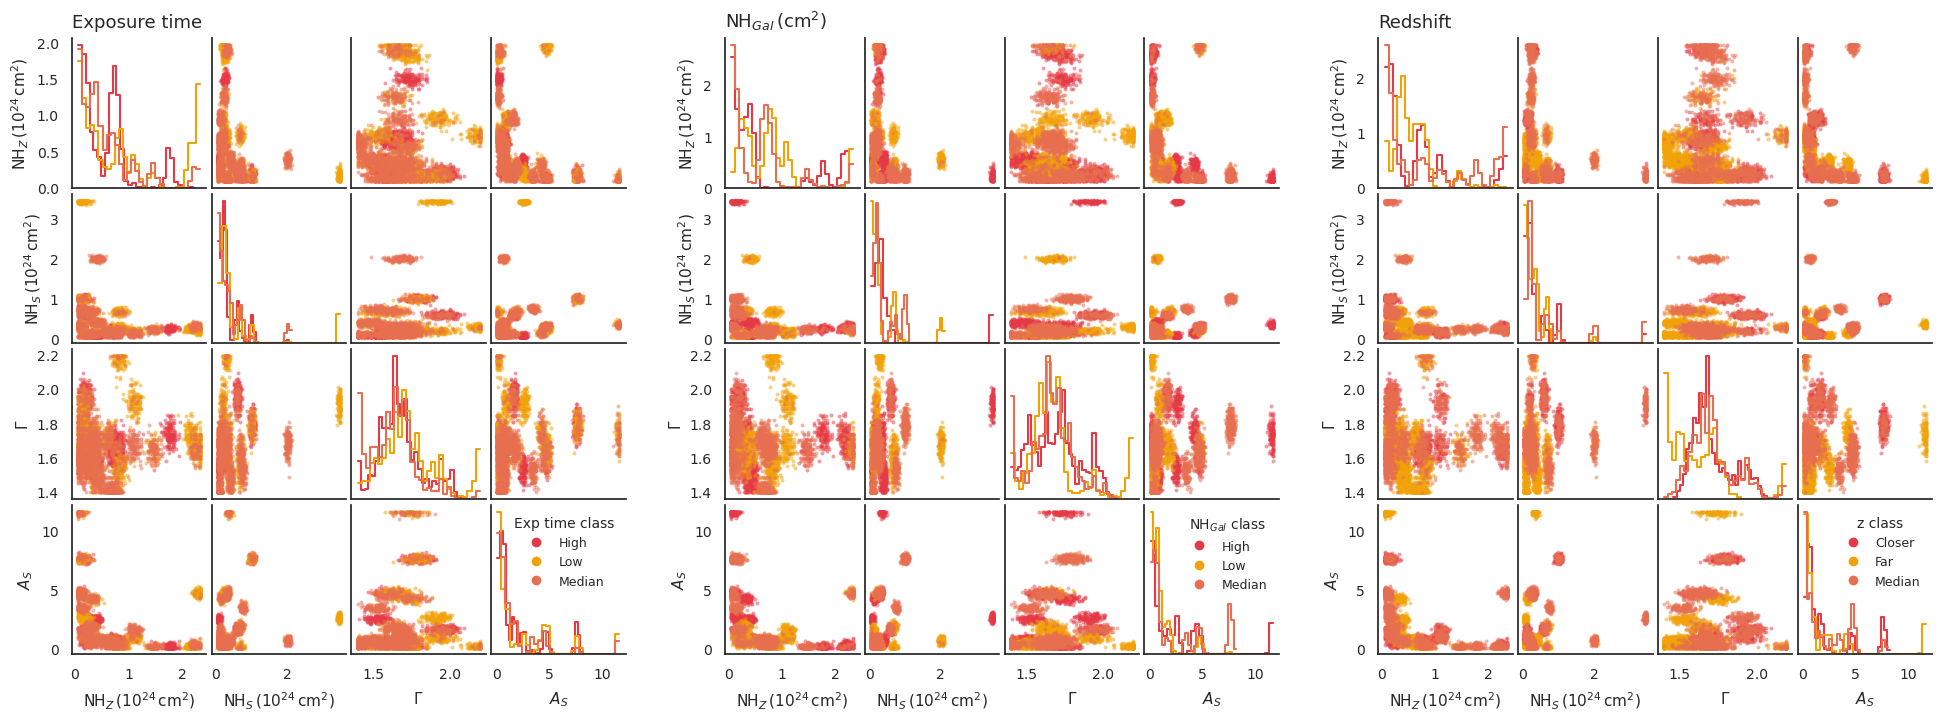

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from matplotlib.lines import Line2D
import numpy as np

# ---------- Estilo general ----------
sns.set_theme(style="white")
plt.rcParams.update({
    "axes.titlesize": 13,
    "axes.labelsize": 11,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10
})

vars_list = ['N_H_Z', 'N_H_S', 'Gamma', 'A_S']
x_labels = [
    r'NH$_{Z} \/ (10^{24}\,\mathrm{cm}^2)$',
    r'NH$_{S} \/ (10^{24}\,\mathrm{cm}^2)$',
    r'$\Gamma$',
    r'$A_{S}$'
]

# Paleta 1 - Cálida
colors_warm = ["#E63946", "#F1A208", "#E76F51"]

# Paleta 2 - Fría
colors_cool = ["#457B9D", "#1D3557", "#A8DADC"]

# Paleta 3 - Neutra/Tierra
colors_earth = ["#606C38", "#283618", "#DDA15E"]

# ---------- Clases ----------
df_val5['DOUBLE_EXP_TIME_(s)_class'] = pd.cut(
    df_val5['DOUBLE_EXP_TIME_(s)'],
    bins=[df_val5['DOUBLE_EXP_TIME_(s)'].min(),
          df_val5['DOUBLE_EXP_TIME_(s)'].quantile(1/3),
          df_val5['DOUBLE_EXP_TIME_(s)'].quantile(2/3),
          df_val5['DOUBLE_EXP_TIME_(s)'].max()],
    labels=['Low', 'Median', 'High'], include_lowest=True
)

df_val5['nH_G_class'] = pd.cut(
    df_val5['nH_G'],
    bins=[df_val5['nH_G'].min(),
          df_val5['nH_G'].quantile(1/3),
          df_val5['nH_G'].quantile(2/3),
          df_val5['nH_G'].max()],
    labels=['Low', 'Median', 'High'], include_lowest=True
)

df_val5['z_class'] = pd.cut(
    df_val5['z'],
    bins=[df_val5['z'].min(),
          df_val5['z'].quantile(1/3),
          df_val5['z'].quantile(2/3),
          df_val5['z'].max()],
    labels=['Closer', 'Median', 'Far'], include_lowest=True
)

grids_info = [
    ("Exposure time", 'DOUBLE_EXP_TIME_(s)_class'),
    (r'NH$_{Gal} \/ (\mathrm{cm}^2)$', 'nH_G_class'),
    ("Redshift", 'z_class'),
]

# ---------- Límites comunes por variable (opcional, queda prolijo) ----------
limits = {}
for v in vars_list:
    col = df_val5[v].to_numpy()
    col = col[np.isfinite(col)]
    if col.size:
        lo, hi = np.percentile(col, [0.5, 99.5])
        pad = 0.05 * (hi - lo if hi > lo else 1.0)
        limits[v] = (lo - pad, hi + pad)
    else:
        limits[v] = (0, 1)

# ---------- Función para dibujar una “pairgrid” dentro de un SubplotSpec ----------
def draw_pairgrid_in_cell(fig, outer_spec, data, hue_col, title, palette_name=colors_warm):
    n = len(vars_list)
    inner = GridSpecFromSubplotSpec(n, n, subplot_spec=outer_spec,
                                    wspace=0.04, hspace=0.04)

    # Asegurar orden y paleta
    hue_series = data[hue_col].dropna()
    hue_order = sorted(hue_series.unique(), key=lambda x: str(x))
    palette = sns.color_palette(palette_name, n_colors=len(hue_order))

    # Map para colores
    color_map = {k: palette[i] for i, k in enumerate(hue_order)}

    axs = [[None]*n for _ in range(n)]
    for i in range(n):
        for j in range(n):
            ax = fig.add_subplot(inner[i, j])
            axs[i][j] = ax

            xvar = vars_list[j]
            yvar = vars_list[i]

            if i == j:
                # Diagonal: hist por clase
                for k in hue_order:
                    dsub = data[data[hue_col] == k]
                    sns.histplot(dsub, x=xvar, stat='density', element='step',
                                 fill=False, bins=30, common_norm=False,
                                 ax=ax, color=color_map[k])
                ax.set_xlim(limits[xvar])
            else:
                # Off-diagonal: scatter
                for k in hue_order:
                    dsub = data[data[hue_col] == k]
                    ax.scatter(dsub[xvar], dsub[yvar], s=8, alpha=0.5,
                               color=color_map[k], linewidths=0, rasterized=True)
                ax.set_xlim(limits[xvar]); ax.set_ylim(limits[yvar])

            # Etiquetas sólo en borde externo
            if i < n-1:
                ax.set_xlabel("")
                ax.set_xticklabels([])
            else:
                ax.set_xlabel(x_labels[j], labelpad=6)

            if j > 0:
                ax.set_ylabel("")
                ax.set_yticklabels([])
            else:
                ax.set_ylabel(x_labels[i])

            sns.despine(ax=ax)

    # Título del bloque (arriba-izquierda)
    axs[0][0].set_title(title, loc='left', pad=8)

    # Leyenda en la esquina del bloque (sobre el diagonal [0,0])
    # Mapear el hue_col al nombre que querés en la leyenda
    legend_titles = {'DOUBLE_EXP_TIME_(s)_class': 'Exp time class',
    'nH_G_class': r'NH$_{Gal}$ class',
    'z_class': 'z class'
    }

    
    handles = [Line2D([0], [0], marker='o', linestyle='',
                      markersize=6, color=color_map[k], label=str(k))
               for k in hue_order]
    axs[-1][-1].legend(handles=handles, title=legend_titles.get(hue_col, hue_col), frameon=False,
                     loc='upper right',fontsize=9, title_fontsize=10)

# ---------- Figura 1×3 y dibujo de los tres bloques ----------
fig = plt.figure(figsize=(24, 8))
outer = GridSpec(1, 3, figure=fig, wspace=0.18)

for idx, (title, hue_col) in enumerate(grids_info):
    draw_pairgrid_in_cell(fig, outer[idx], df_val5, hue_col, title, palette_name=colors_warm)

plt.tight_layout()
plt.savefig(path_figures + 'parameters_triple_pairgrid.png', dpi=300, bbox_inches='tight')
plt.show()


# Predicted parameter

<Figure size 800x240 with 0 Axes>

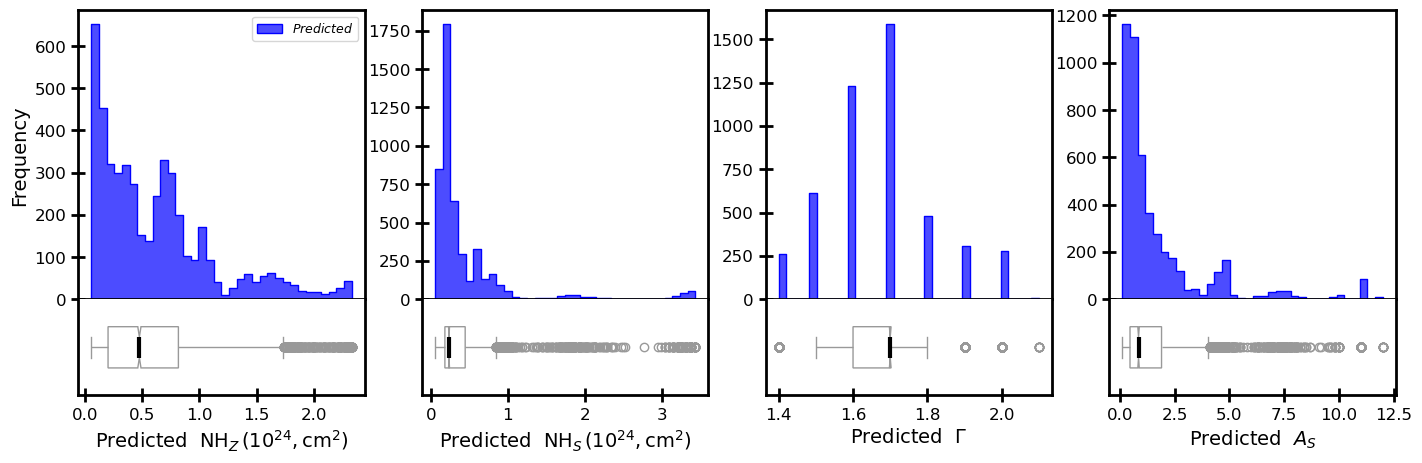

In [10]:
# Etiquetas
x_labels = ['Predicted' + r'  NH$_{Z} \/ (10^{24}, \mathrm{cm}^2)$',
            'Predicted' + r'  NH$_{S} \/ (10^{24}, \mathrm{cm}^2)$',
            'Predicted' + r'  $\Gamma$', 
            'Predicted' + r'  $A_{S}$']


plt.rcParams['figure.figsize'] = 12, 7
plt.figure(figsize=(10, 3), dpi=80, facecolor='b', edgecolor='blue')

### subfiguras
fig, axes = plt.subplots(2, 4, figsize=(17, 5), sharex='col', gridspec_kw={"height_ratios": (3, 1)})

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0)

axes = axes.flatten()


df_clean = df_val5[pred_parameters]

##### Definiciones:
medianprops = dict(color='black', linewidth=3)
# Define color grey33
grey33 = (85/255, 85/255)


# Iterar por columnas y ejes
for i, (ax, col) in enumerate(zip(axes[:4], df_clean.columns)):
    bines = np.linspace(df_clean[col].min(), df_clean[col].max(), num=35)
    sns.histplot(data=df_clean, x=col, bins=bines, ax=ax, element='step', alpha=0.7, color='blue', label=r'$Predicted$')

    if i == 0:  # Solo en el primer gráfico (primer cuadrante)
        ax.legend(fontsize=9, loc='upper right')
    else:  # Elimina la leyenda de los demás subgráficos
        ax.legend_.remove() if ax.get_legend() else None

    ########################### Leyendza


    ax.tick_params(bottom=False, labelbottom=False,
               top = False, labeltop = False,
               right = False, labelright = False,
               left = True, labelleft = True)
    ax.tick_params(which='major', direction='inout',
               length=10, width=2, colors='black',
               grid_color='r', grid_alpha=0.5)
    [i.set_linewidth(2.0) for i in ax.spines.values()]

    # bordes
    sns.despine (ax = ax, left=False, bottom=False, top=False, right=False)
    # Tamaño
    ax.yaxis.set_tick_params(labelsize=12)
    [i.set_linewidth(2.0) for i in ax.spines.values()]
    # sin label
    ax.set_ylabel(' ', fontsize=14)

###############################################################################################################################################################################
for i, (ax, col) in enumerate(zip(axes[4:], df_clean.columns)):########################### Leyendza
    boxF = sns.boxplot(data=df_clean, x=col, ax=ax, notch=True, color='white', orient='h', width=df_clean.shape[0]*0.00009, medianprops=medianprops, showfliers=True)
    ax.set_xlabel(x_labels[i], fontsize=14)

    ax.tick_params(bottom=True, labelbottom=True,
               top = False, labeltop = False,
               right = False, labelright = False,
               left = False, labelleft = False)
    ax.tick_params(which='major', direction='inout',jwst_zoa_I_ToSubmit
               length=10, width=2, colors='black',
               grid_color='r', grid_alpha=0.5)
    [i.set_linewidth(2.0) for i in ax.spines.values()]

    # bordes
    sns.despine (ax=ax, left=False, bottom=False, top=True, right=False)
    # tamaño
    ax.xaxis.set_tick_params(labelsize=12)
    [i.set_linewidth(2.0) for i in ax.spines.values()]
    
    # Ajustar el borde y la transparencia
    for artist in boxF.artists:
        artist.set_edgecolor('green')  # Color del borde
        artist.set_linewidth(2)  # Grosor del borde
        artist.set_facecolor('white')  # Asegurar que el relleno sea blanco
        artist.set_alpha(0.7)  # Transparencia del borde



axes[0].set_ylabel('Frequency', fontsize=14)

plt.savefig(path_figures+'pre_Gau.png', format ='png',  bbox_inches='tight')

#plt.tight_layout()
plt.show()

# Comparison between fake parameter and predicted parameter

<Figure size 800x240 with 0 Axes>

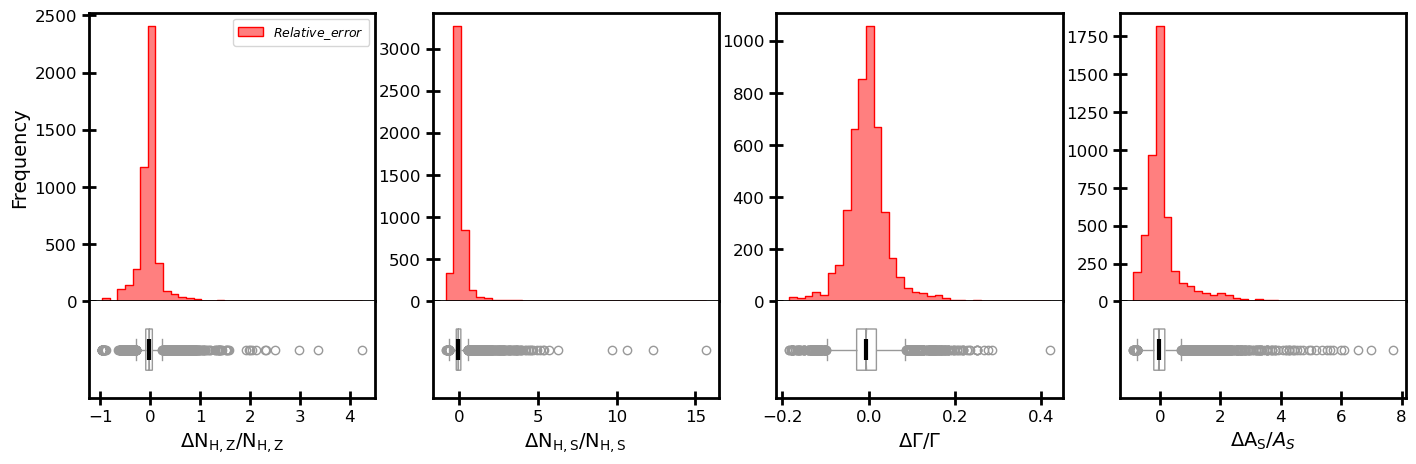

In [11]:
# Etiquetas
x_labels = [r'$\Delta \mathrm{N}_{\mathrm{H,Z}} / \mathrm{N}_{\mathrm{H,Z}}$',
            r'$\Delta \mathrm{N}_{\mathrm{H,S}} / \mathrm{N}_{\mathrm{H,S}}$',
            r'$\Delta \Gamma / \Gamma$',
            r'$\Delta \mathrm{A}_{\mathrm{S}} / A_{S}$']


plt.rcParams['figure.figsize'] = 12, 7
plt.figure(figsize=(10, 3), dpi=80, facecolor='b', edgecolor='blue')

### subfiguras
fig, axes = plt.subplots(2, 4, figsize=(17, 5), sharex='col', gridspec_kw={"height_ratios": (3, 1)})

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0)

axes = axes.flatten()


df_clean = df_val5[relative_error_columns]

##### Definiciones:
medianprops = dict(color='black', linewidth=3)
# Define color grey33
grey33 = (85/255, 85/255)


# Iterar por columnas y ejes
for i, (ax, col) in enumerate(zip(axes[:4], df_clean.columns)):
    bines = np.linspace(df_clean[col].min(), df_clean[col].max(), num=35)
    sns.histplot(data=df_clean, x=col, bins=bines, ax=ax, element='step', alpha=0.5, color='red', label=r'$Relative \_ error$')

    if i == 0:  # Solo en el primer gráfico (primer cuadrante)
        ax.legend(fontsize=9, loc='upper right')
    else:  # Elimina la leyenda de los demás subgráficos
        ax.legend_.remove() if ax.get_legend() else None

    ########################### Leyendza


    ax.tick_params(bottom=False, labelbottom=False,
               top = False, labeltop = False,
               right = False, labelright = False,
               left = True, labelleft = True)
    ax.tick_params(which='major', direction='inout',
               length=10, width=2, colors='black',
               grid_color='r', grid_alpha=0.5)
    [i.set_linewidth(2.0) for i in ax.spines.values()]

    # bordes
    sns.despine (ax = ax, left=False, bottom=False, top=False, right=False)
    # Tamaño
    ax.yaxis.set_tick_params(labelsize=12)
    [i.set_linewidth(2.0) for i in ax.spines.values()]
    # sin label
    ax.set_ylabel(' ', fontsize=14)

###############################################################################################################################################################################
for i, (ax, col) in enumerate(zip(axes[4:], df_clean.columns)):########################### Leyendza
    boxF = sns.boxplot(data=df_clean, x=col, ax=ax, notch=True, color='white', orient='h', width=df_clean.shape[0]*0.00009, medianprops=medianprops, showfliers=True)
    ax.set_xlabel(x_labels[i], fontsize=14)

    ax.tick_params(bottom=True, labelbottom=True,
               top = False, labeltop = False,
               right = False, labelright = False,
               left = False, labelleft = False)
    ax.tick_params(which='major', direction='inout',
               length=10, width=2, colors='black',
               grid_color='r', grid_alpha=0.5)
    [i.set_linewidth(2.0) for i in ax.spines.values()]

    # bordes
    sns.despine (ax=ax, left=False, bottom=False, top=True, right=False)
    # tamaño
    ax.xaxis.set_tick_params(labelsize=12)
    [i.set_linewidth(2.0) for i in ax.spines.values()]
    
    # Ajustar el borde y la transparencia
    for artist in boxF.artists:
        artist.set_edgecolor('green')  # Color del borde
        artist.set_linewidth(2)  # Grosor del borde
        artist.set_facecolor('white')  # Asegurar que el relleno sea blanco
        artist.set_alpha(0.7)  # Transparencia del borde



axes[0].set_ylabel('Frequency', fontsize=14)

plt.savefig(path_figures+'comparison_Gau', format ='png',  bbox_inches='tight')

#plt.tight_layout()
plt.show()

<Figure size 800x240 with 0 Axes>

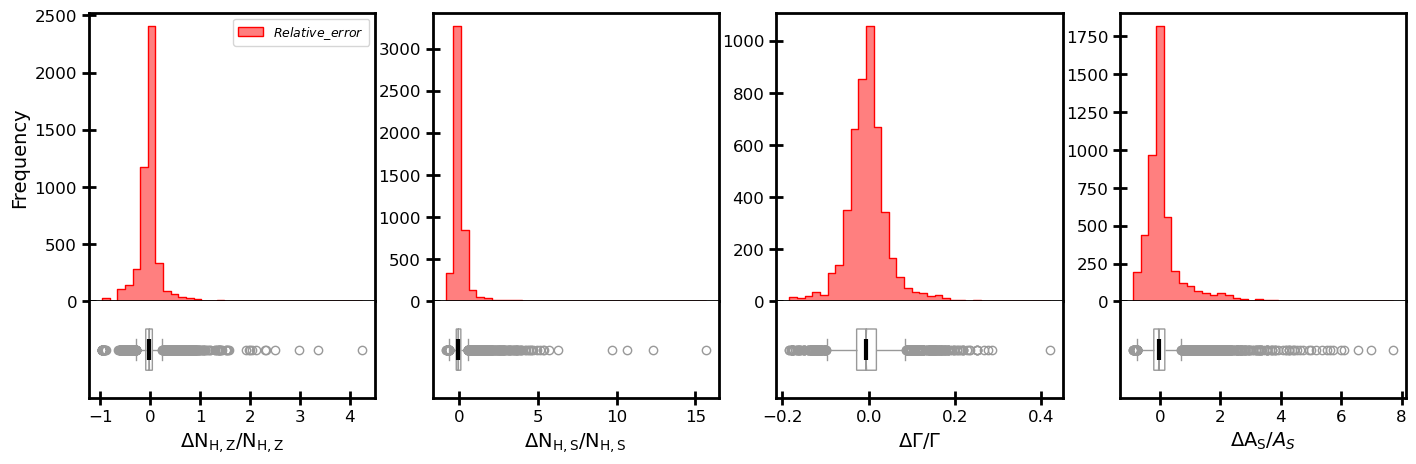

In [12]:
# Etiquetas
x_labels = [r'$\Delta \mathrm{N}_{\mathrm{H,Z}} / \mathrm{N}_{\mathrm{H,Z}}$',
            r'$\Delta \mathrm{N}_{\mathrm{H,S}} / \mathrm{N}_{\mathrm{H,S}}$',
            r'$\Delta \Gamma / \Gamma$',
            r'$\Delta \mathrm{A}_{\mathrm{S}} / A_{S}$']


plt.rcParams['figure.figsize'] = 12, 7
plt.figure(figsize=(10, 3), dpi=80, facecolor='b', edgecolor='blue')

### subfiguras
fig, axes = plt.subplots(2, 4, figsize=(17, 5), sharex='col', gridspec_kw={"height_ratios": (3, 1)})

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0)

axes = axes.flatten()


df_clean = df_val5[relative_error_columns]

##### Definiciones:
medianprops = dict(color='black', linewidth=3)
# Define color grey33
grey33 = (85/255, 85/255)


# Iterar por columnas y ejes
for i, (ax, col) in enumerate(zip(axes[:4], df_clean.columns)):
    bines = np.linspace(df_clean[col].min(), df_clean[col].max(), num=35)
    sns.histplot(data=df_clean, x=col, bins=bines, ax=ax, element='step', alpha=0.5, color='red', label=r'$Relative \_ error$')

    if i == 0:  # Solo en el primer gráfico (primer cuadrante)
        ax.legend(fontsize=9, loc='upper right')
    else:  # Elimina la leyenda de los demás subgráficos
        ax.legend_.remove() if ax.get_legend() else None

    ########################### Leyendza


    ax.tick_params(bottom=False, labelbottom=False,
               top = False, labeltop = False,
               right = False, labelright = False,
               left = True, labelleft = True)
    ax.tick_params(which='major', direction='inout',
               length=10, width=2, colors='black',
               grid_color='r', grid_alpha=0.5)
    [i.set_linewidth(2.0) for i in ax.spines.values()]

    # bordes
    sns.despine (ax = ax, left=False, bottom=False, top=False, right=False)
    # Tamaño
    ax.yaxis.set_tick_params(labelsize=12)
    [i.set_linewidth(2.0) for i in ax.spines.values()]
    # sin label
    ax.set_ylabel(' ', fontsize=14)

###############################################################################################################################################################################
for i, (ax, col) in enumerate(zip(axes[4:], df_clean.columns)):########################### Leyendza
    boxF = sns.boxplot(data=df_clean, x=col, ax=ax, notch=True, color='white', orient='h', width=df_clean.shape[0]*0.00009, medianprops=medianprops, showfliers=True)
    ax.set_xlabel(x_labels[i], fontsize=14)

    ax.tick_params(bottom=True, labelbottom=True,
               top = False, labeltop = False,
               right = False, labelright = False,
               left = False, labelleft = False)
    ax.tick_params(which='major', direction='inout',
               length=10, width=2, colors='black',
               grid_color='r', grid_alpha=0.5)
    [i.set_linewidth(2.0) for i in ax.spines.values()]

    # bordes
    sns.despine (ax=ax, left=False, bottom=False, top=True, right=False)
    # tamaño
    ax.xaxis.set_tick_params(labelsize=12)
    [i.set_linewidth(2.0) for i in ax.spines.values()]
    
    # Ajustar el borde y la transparencia
    for artist in boxF.artists:
        artist.set_edgecolor('green')  # Color del borde
        artist.set_linewidth(2)  # Grosor del borde
        artist.set_facecolor('white')  # Asegurar que el relleno sea blanco
        artist.set_alpha(0.7)  # Transparencia del borde



axes[0].set_ylabel('Frequency', fontsize=14)

plt.savefig(path_figures+'comparison_Gau', format ='png',  bbox_inches='tight')

#plt.tight_layout()
plt.show()

<Figure size 800x240 with 0 Axes>

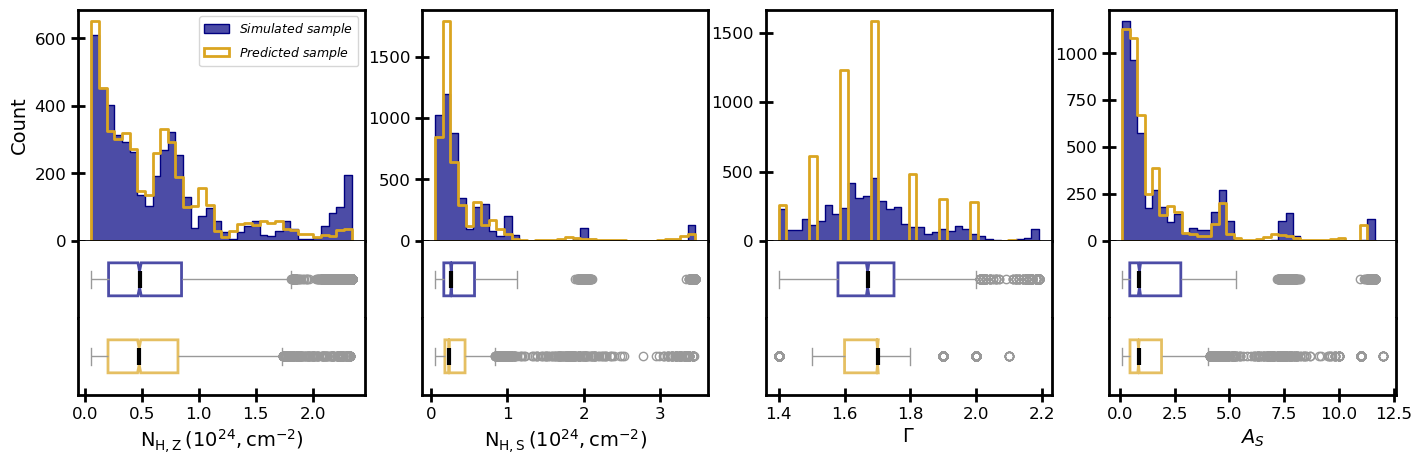

In [13]:
# Etiquetas
x_labels = [r'$\mathrm{N}_{\mathrm{H,Z}} \/ (10^{24}, \mathrm{cm}^{-2})$',
            r'$\mathrm{N}_{\mathrm{H,S}} \/ (10^{24}, \mathrm{cm}^{-2})$',
            r'$\Gamma$', r'$A_{S}$', 'Exposure time', 'PL_NORM']

plt.rcParams['figure.figsize'] = 12, 7
plt.figure(figsize=(10, 3), dpi=80, facecolor='b', edgecolor='blue')

### subfiguras
fig, axes = plt.subplots(3, 4, figsize=(17, 5), sharex='col', gridspec_kw={"height_ratios": (3, 1, 1)})

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0)

axes = axes.flatten()


##### Definiciones:
medianprops = dict(color='black', linewidth=3)


df_clean = df_val5[fake_parameters]
df_clean_n  = df_val5[pred_parameters]

# Iterar por columnas y ejes
for i, (ax, col_fake, col_pred) in enumerate(zip(axes[:4], df_clean.columns, df_clean_n.columns)):
    bines = np.linspace(df_clean[col_fake].min(), df_clean[col_fake].max(), num=35)
    sns.histplot(data=df_clean, x=col_fake, bins=bines, ax=ax, 
                 element='step', alpha=0.7, color='navy', label=r'$Simulated \ sample$')
    sns.histplot(data=df_clean_n, x=col_pred, bins=bines, ax=ax, 
                 element='step', alpha=0, color='goldenrod', label=r'$Predicted \ sample$', linewidth=2)

    ########################### Leyenda
    if i == 0:  # Solo en el primer gráfico (primer cuadrante)
        ax.legend(fontsize=9, loc='upper right')
    else:  # Elimina la leyenda de los demás subgráficos
        ax.legend_.remove() if ax.get_legend() else None


    ax.tick_params(bottom=False, labelbottom=False,
               top = False, labeltop = False,
               right = False, labelright = False,
               left = True, labelleft = True)
    ax.tick_params(which='major', direction='inout',
               length=10, width=2, colors='black',
               grid_color='r', grid_alpha=0.5)
    [i.set_linewidth(2.0) for i in ax.spines.values()]

    # bordes
    sns.despine (ax = ax, left=False, bottom=False, top=False, right=False)
    # Tamaño
    ax.yaxis.set_tick_params(labelsize=12)
    [i.set_linewidth(2.0) for i in ax.spines.values()]
    # sin label
    ax.set_ylabel(' ', fontsize=14)

###############################################################################################################################################################################

for i, (ax, col) in enumerate(zip(axes[4:8], df_clean.columns)):
    boxF = sns.boxplot(data=df_clean, x=col, ax=ax, notch= True, 
                       color='white', width=df_clean.shape[0]*0.00009, 
                       medianprops=medianprops, orient='h', showfliers=True)

    ax.tick_params(bottom=False, labelbottom=False,
               top = False, labeltop = False,
               right = False, labelright = False,
               left = False, labelleft = False)
    ax.tick_params(which='major', direction='inout',
               length=10, width=2, colors='black',
               grid_color='r', grid_alpha=0.5)
    [i.set_linewidth(2.0) for i in ax.spines.values()]

    # bordes
    sns.despine (ax = ax, left=False, bottom=True, top=True, right=False)
    ax.xaxis.set_tick_params(labelsize=12)
    
    [i.set_linewidth(2.0) for i in ax.spines.values()]

    # Ajustar el borde y la transparencia
    for patch in boxF.patches:
        patch.set_edgecolor('navy')
        patch.set_linewidth(2)
        patch.set_facecolor('white')
        patch.set_alpha(0.7)

###############################################################################################################################################################################

for i, (ax, col) in enumerate(zip(axes[8:], df_clean_n.columns)):########################### Leyendza
    boxS = sns.boxplot(data=df_clean_n, x=col, ax=ax, notch=True, color='white', orient='h', 
                       width=df_clean_n.shape[0]*0.00009, medianprops=medianprops, showfliers=True)
    ax.set_xlabel(x_labels[i], fontsize=14)

    ax.tick_params(bottom=True, labelbottom=True,
               top = False, labeltop = False,
               right = False, labelright = False,
               left = False, labelleft = False)
    ax.tick_params(which='major', direction='inout',
               length=10, width=2, colors='black',
               grid_color='r', grid_alpha=0.5)
    [i.set_linewidth(2.0) for i in ax.spines.values()]

    # bordes
    sns.despine (ax=ax, left=False, bottom=False, top=True, right=False)
    # tamaño
    
    ax.xaxis.set_tick_params(labelsize=12)
    [i.set_linewidth(2.0) for i in ax.spines.values()]

    # Ajustar el borde y la transparencia
    for patch in boxS.patches:
        patch.set_edgecolor('goldenrod')
        patch.set_linewidth(2)
        patch.set_facecolor('white')
        patch.set_alpha(0.7)



axes[0].set_ylabel('Count', fontsize=14)

#plt.setp(boxF.artists, hatch="\\\\", edgecolor=grey33)

#plt.tight_layout()
#plt.savefig(path_figures+'physical_parameters.pdf', format ='pdf',  bbox_inches='tight')
plt.savefig(path_figures+'physical_parameters_n_Gau.png', format ='png',  bbox_inches='tight')
plt.show()

In [14]:
# Calculo de distribucion de diferencias de valores predichos en comparacion para calcular el sigma 

N_H_Z: 4418/4760 (92.82%) dentro de ±1σ
N_H_S: 4034/4760 (84.75%) dentro de ±1σ
Gamma: 3840/4760 (80.67%) dentro de ±1σ
A_S: 4260/4760 (89.50%) dentro de ±1σ


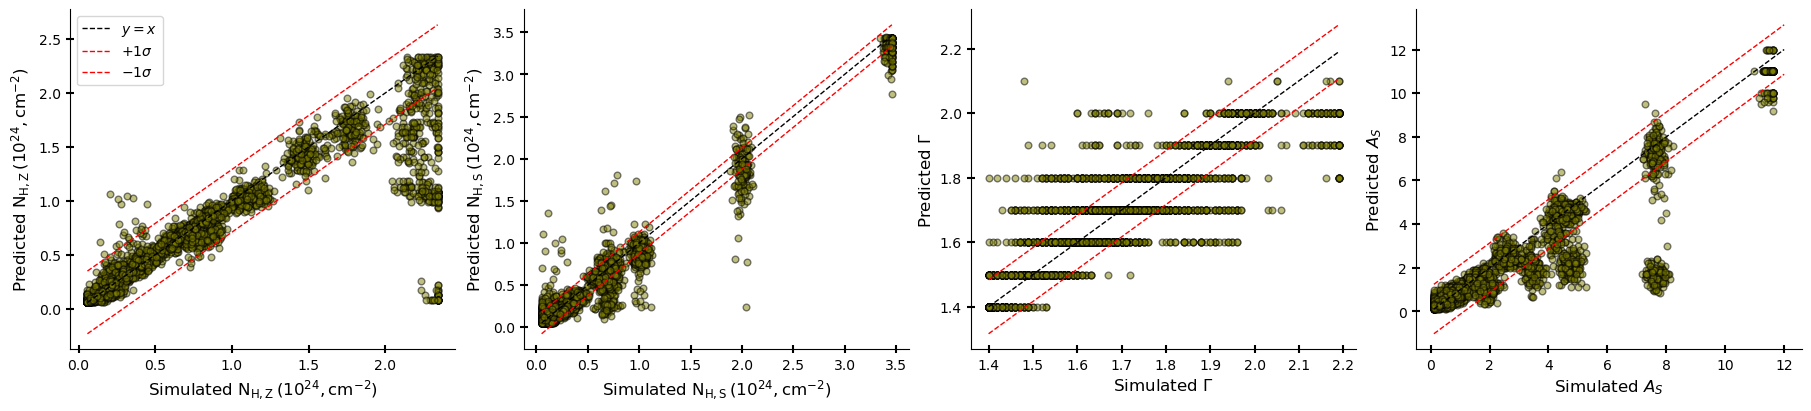

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Columnas reales y predichas
fake_parameters = ['N_H_Z', 'N_H_S', 'Gamma', 'A_S']
pred_parameters = ['N_H_Z_pred', 'N_H_S_pred', 'Gamma_pred', 'A_S_pred']

# Etiquetas
x_labels = [r'$\mathrm{N}_{\mathrm{H,Z}}  \/ (10^{24}, \mathrm{cm}^{-2})$',
            r'$\mathrm{N}_{\mathrm{H,S}}  \/ (10^{24}, \mathrm{cm}^{-2})$',
            r'$\Gamma$',
            r'$A_{S}$']

# Crear figura
fig, axes = plt.subplots(1, 4, figsize=(18, 4), constrained_layout=True)

for i, (ax, true_col, pred_col) in enumerate(zip(axes, fake_parameters, pred_parameters)):

    # Diferencia predicho - verdadero
    delta = df_val5[pred_col] - df_val5[true_col]
    

    # Calcular sigma68 (percentil 84 - 16 / 2) o std
    #sigma68 = np.percentile(delta, 84) - np.percentile(delta, 16)
    #sigma68 /= 2  # Esto es sigma68 (más robusto que std)
    sigma = np.std(delta)
    # Calcular cuántos están dentro de ±1σ
    within_sigma = np.abs(delta) <= sigma
    num_within_sigma = within_sigma.sum()
    total_points = len(delta)
    percentage_within_sigma = 100 * num_within_sigma / total_points

    print(f"{true_col}: {num_within_sigma}/{total_points} ({percentage_within_sigma:.2f}%) dentro de ±1σ")

    # Valores extremos para las líneas
    min_val = min(df_val5[true_col].min(), df_val5[pred_col].min())
    max_val = max(df_val5[true_col].max(), df_val5[pred_col].max())

    # Puntos
    ax.scatter(df_val5[true_col], df_val5[pred_col],
               alpha=0.5, edgecolor='k', color='olive', s=23)

    # Línea identidad
    ax.plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=1, label=r'$y = x$')

    # Líneas de error ±σ
    ax.plot([min_val, max_val], [min_val + sigma, max_val + sigma],
            'r--', linewidth=1, label=r'$+1\sigma$')
    ax.plot([min_val, max_val], [min_val - sigma, max_val - sigma],
            'r--', linewidth=1, label=r'$-1\sigma$')

    # Etiquetas
    ax.set_xlabel(f'Simulated {x_labels[i]}', fontsize=12)
    ax.set_ylabel(f'Predicted {x_labels[i]}', fontsize=12)
    ax.tick_params(direction='inout', length=6, width=1.5)
    sns.despine(ax=ax)

    if i == 0:
        ax.legend()

# Guardar figura
plt.savefig(path_figures + 'fake_pred_sigma_Gau.png', format='png', bbox_inches='tight')
plt.show()


N_H_Z: 4418/4760 (92.82%) dentro de ±1σ
N_H_S: 4034/4760 (84.75%) dentro de ±1σ
Gamma: 3840/4760 (80.67%) dentro de ±1σ
A_S: 4260/4760 (89.50%) dentro de ±1σ


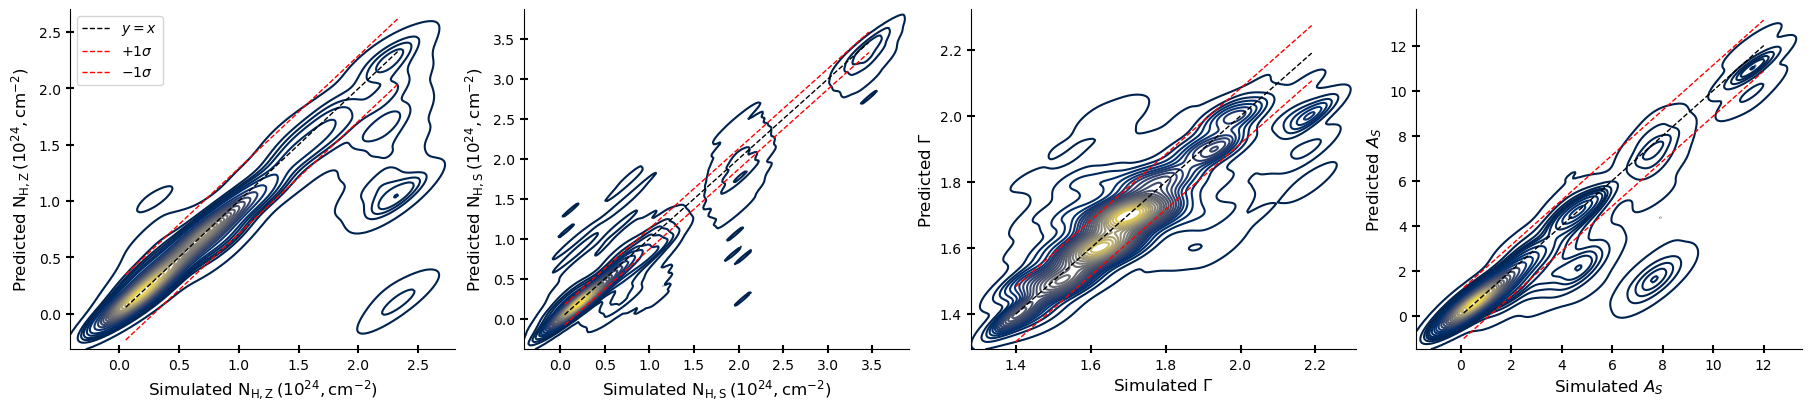

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Columnas reales y predichas
fake_parameters = ['N_H_Z', 'N_H_S', 'Gamma', 'A_S']
pred_parameters = ['N_H_Z_pred', 'N_H_S_pred', 'Gamma_pred', 'A_S_pred']

# Etiquetas
x_labels = [r'$\mathrm{N}_{\mathrm{H,Z}}  \/ (10^{24}, \mathrm{cm}^{-2})$',
            r'$\mathrm{N}_{\mathrm{H,S}}  \/ (10^{24}, \mathrm{cm}^{-2})$',
            r'$\Gamma$', r'$A_{S}$']

# Crear figura
fig, axes = plt.subplots(1, 4, figsize=(18, 4), constrained_layout=True)

for i, (ax, true_col, pred_col) in enumerate(zip(axes, fake_parameters, pred_parameters)):
    x = df_val5[true_col]
    y = df_val5[pred_col]
    
    # Eliminar NaNs
    mask = np.isfinite(x) & np.isfinite(y)
    x, y = x[mask], y[mask]

    # Diferencia predicho - verdadero
    delta = y - x
    sigma = np.std(delta)
    within_sigma = np.abs(delta) <= sigma
    num_within_sigma = within_sigma.sum()
    total_points = len(delta)
    percentage_within_sigma = 100 * num_within_sigma / total_points

    print(f"{true_col}: {num_within_sigma}/{total_points} ({percentage_within_sigma:.2f}%) dentro de ±1σ")

    min_val = min(x.min(), y.min())
    max_val = max(x.max(), y.max())

    # Mapa de densidad 2D con sns.kdeplot
    sns.kdeplot(x=x, y=y, ax=ax, cmap='cividis', fill=False, levels=25, thresh=0.005)

    # Línea identidad y ±σ
    ax.plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=1, label=r'$y = x$')
    ax.plot([min_val, max_val], [min_val + sigma, max_val + sigma],
            'r--', linewidth=1, label=r'$+1\sigma$')
    ax.plot([min_val, max_val], [min_val - sigma, max_val - sigma],
            'r--', linewidth=1, label=r'$-1\sigma$')

    # Etiquetas
    ax.set_xlabel(f'Simulated {x_labels[i]}', fontsize=12)
    ax.set_ylabel(f'Predicted {x_labels[i]}', fontsize=12)
    ax.tick_params(direction='inout', length=6, width=1.5)
    sns.despine(ax=ax)


    if i == 0:
        ax.legend()

plt.savefig(path_figures + 'fake_pred_density_map_Gau.png', format='png', bbox_inches='tight')
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Columnas reales y predichas
fake_parameters = ['N_H_Z', 'N_H_S', 'Gamma', 'A_S']
pred_parameters = ['N_H_Z_pred', 'N_H_S_pred', 'Gamma_pred', 'A_S_pred']

# Etiquetas
x_labels = [r'$\mathrm{N}_{\mathrm{H,Z}}  \/ (10^{24}, \mathrm{cm}^{-2})$',
            r'$\mathrm{N}_{\mathrm{H,S}}  \/ (10^{24}, \mathrm{cm}^{-2})$',
            r'$\Gamma$', r'$A_{S}$']

# Crear figura
fig, axes = plt.subplots(1, 4, figsize=(18, 4), constrained_layout=True)

for i, (ax, true_col, pred_col) in enumerate(zip(axes, fake_parameters, pred_parameters)):
    x = df_val5[true_col]
    y = df_val5[pred_col]
    
    # Eliminar NaNs
    mask = np.isfinite(x) & np.isfinite(y)
    x, y = x[mask], y[mask]

    # Diferencia predicho - verdadero
    delta = y - x
    sigma = np.std(delta)
    within_sigma = np.abs(delta) <= sigma
    num_within_sigma = within_sigma.sum()
    total_points = len(delta)
    percentage_within_sigma = 100 * num_within_sigma / total_points

    print(f"{true_col}: {num_within_sigma}/{total_points} ({percentage_within_sigma:.2f}%) dentro de ±1σ")

    min_val = min(x.min(), y.min())
    max_val = max(x.max(), y.max())

    # Mapa de densidad 2D con sns.kdeplot
    sns.kdeplot(x=x, y=y, ax=ax, cmap='cividis', fill=False, levels=25, thresh=0.005)
    sc = sns.kdeplot(x=x, y=y, ax=ax, cmap='cividis', fill=False, levels=25, thresh=0.005)

    # Línea identidad y ±σ
    ax.plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=1, label=r'$y = x$')
    ax.plot([min_val, max_val], [min_val + sigma, max_val + sigma],
            'r--', linewidth=1, label=r'$+1\sigma$')
    ax.plot([min_val, max_val], [min_val - sigma, max_val - sigma],
            'r--', linewidth=1, label=r'$-1\sigma$')

    # Etiquetas
    ax.set_xlabel(f'Simulated {x_labels[i]}', fontsize=14)
    ax.set_ylabel(f'Predicted {x_labels[i]}', fontsize=14)
    ax.tick_params(direction='inout', length=6, width=1.5)
    sns.despine(ax=ax)

    # Texto en la esquina inferior derecha de cada subplot
    ax.text(
        0.95, 0.05,  # posición relativa dentro del subplot (x=95% ancho, y=5% alto)
        f"{percentage_within_sigma:.2f}% within ±1σ",
        color='red',
        fontsize=13,
        ha='right', va='bottom',
        transform=ax.transAxes
    )

    if i == 0:
        ax.legend()

from matplotlib.ticker import FormatStrFormatter
# Barra de color (fuera del bucle)
cbar = fig.colorbar(sc.collections[0], ax=axes.ravel().tolist(), label='Density')
cbar.ax.yaxis.set_major_formatter(FormatStrFormatter("%.4f"))

plt.savefig(path_figures + 'fake_pred_density_map_Gau.pdf', format='pdf', bbox_inches='tight')
plt.show()

N_H_Z: 4418/4760 (92.82%) dentro de ±1σ
N_H_S: 4034/4760 (84.75%) dentro de ±1σ
Gamma: 3840/4760 (80.67%) dentro de ±1σ
A_S: 4260/4760 (89.50%) dentro de ±1σ


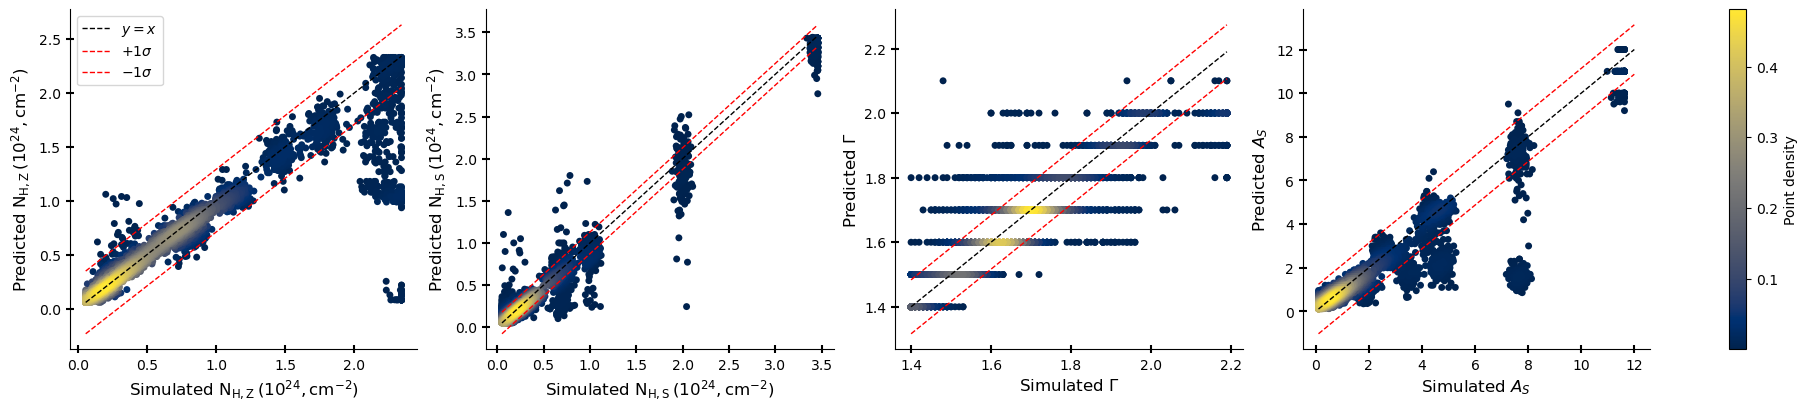

In [17]:
from scipy.stats import gaussian_kde

fig, axes = plt.subplots(1, 4, figsize=(18, 4), constrained_layout=True)

for i, (ax, true_col, pred_col) in enumerate(zip(axes, fake_parameters, pred_parameters)):
    x = df_val5[true_col].values
    y = df_val5[pred_col].values

    # Eliminar NaNs
    mask = np.isfinite(x) & np.isfinite(y)
    x, y = x[mask], y[mask]

    # Calcular densidad
    xy = np.vstack([x, y])
    try:
        z = gaussian_kde(xy)(xy)
    except Exception as e:
        print(f"Error en gaussian_kde para {true_col}: {e}")
        continue

    # Ordenar por densidad para que los puntos densos queden arriba
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]

    # Cálculo de sigma
    delta = y - x
    sigma = np.std(delta)
    within_sigma = np.abs(delta) <= sigma
    num_within_sigma = within_sigma.sum()
    total_points = len(delta)
    percentage_within_sigma = 100 * num_within_sigma / total_points
    print(f"{true_col}: {num_within_sigma}/{total_points} ({percentage_within_sigma:.2f}%) dentro de ±1σ")

    min_val = min(x.min(), y.min())
    max_val = max(x.max(), y.max())

    # Puntos coloreados por densidad
    sc = ax.scatter(x, y, c=z, cmap='cividis', s=25, edgecolor='none')

    # Línea identidad y ±σ
    ax.plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=1, label=r'$y = x$')
    ax.plot([min_val, max_val], [min_val + sigma, max_val + sigma],
            'r--', linewidth=1, label=r'$+1\sigma$')
    ax.plot([min_val, max_val], [min_val - sigma, max_val - sigma],
            'r--', linewidth=1, label=r'$-1\sigma$')

    # Etiquetas
    ax.set_xlabel(f'Simulated {x_labels[i]}', fontsize=12)
    ax.set_ylabel(f'Predicted {x_labels[i]}', fontsize=12)
    ax.tick_params(direction='inout', length=6, width=1.5)
    sns.despine(ax=ax)

    if i == 0:
        ax.legend()

# Barra de color (fuera del bucle)
fig.colorbar(sc, ax=axes.ravel().tolist(), label='Point density')

plt.savefig(path_figures + 'fake_pred_density_scatter_Gau.png', format='png', bbox_inches='tight')
plt.show()


In [ ]:
# Cargar datos
df1 = df_val5  # Asumiendo que ya tienes df_val4 cargado
df2 = pd.read_csv(path_tables + 'observational_NuSTAR_table.csv')
df2 = df2[df2['A_S'] >= 0.1]

# Crear gráfico 3D interactivo
fig = go.Figure()

# Puntos con ruido (gris y transparente)
fig.add_trace(go.Scatter3d(
    x=df1['N_H_Z_pred'],
    y=df1['N_H_S_pred'],
    z=df1['Gamma_pred'],
    mode='markers',
    marker=dict(size=2, color='gray', opacity=0.1),
    name='Predicted parameters on validation set'
))

# Datos originales (rojo y más grandes)
fig.add_trace(go.Scatter3d(
    x=df2['N_H_Z'],
    y=df2['N_H_S'],
    z=df2['Gamma'],
    mode='markers',
    marker=dict(size=5, color='red', opacity=1),
    name='Original data'
))

# Personalizar layout
fig.update_layout(
    scene=dict(
        xaxis_title="NH<sub>Z</sub>  (10<sup>24</sup> cm<sup>-2</sup>)",
        yaxis_title="NH<sub>S</sub>  (10<sup>24</sup> cm<sup>-2</sup>)",
        zaxis_title="Γ"  # código HTML para la letra griega Gamma (Γ)
    ),
    #legend=dict(title='Datos'),
    width=1000,
    height=700
)

# Mostrar gráfico interactivo
fig.show()

# Guardar el gráfico en un archivo HTML
fig.write_html(path_figures+"grafico_interactivo_Gau.html")


/home/vdaza/miniconda3/envs/sbi_env/lib/python3.10/site-packages/kaleido/__init__.py:14: UserWarning:




This means that static image generation (e.g. `fig.write_image()`) will not work.

Please upgrade Plotly to version 6.1.1 or greater, or downgrade Kaleido to version 0.2.1.




3D Interactive Diagram – showing the distributions of the physical parameters $NH_z$, $NH_s$, and $\Gamma$ of the material surrounding AGNs along the x, y, and z axes, respectively. The red points represent the physical parameters obtained using the MyTORUS model (Yaqoob et al. 2009?) from 34 NuSTAR observations. The grey points correspond to physical parameters inferred through simulation-based inference with neural posterior estimation (SBI-NPE, Barret et al. 2024) from 4760 simulated spectra.

In [ ]:
!pip install imageio

In [ ]:
!pip install -U kaleido

In [ ]:
import plotly.graph_objects as go
import numpy as np
import imageio.v2 as imageio
import os

# Crea el mismo gráfico que ya tienes
fig = go.Figure(data=[go.Scatter3d(
    x=[1, 2, 3],
    y=[4, 5, 6],
    z=[7, 8, 9],
    mode='markers',
    marker=dict(size=5)
)])

# Parámetros
output_dir = "frames"
n_frames = 36  # para una rotación suave de 360 grados
elevation = 30  # ángulo de elevación constante
radius = 2      # distancia de la cámara al centro del gráfico

# Crea carpeta de salida
os.makedirs(output_dir, exist_ok=True)
image_paths = []

# Generar frames con distintas posiciones de cámara (azimutal)
for i in range(n_frames):
    azimuth = i * 360 / n_frames
    camera = dict(
        eye=dict(
            x=radius * np.cos(np.radians(azimuth)),
            y=radius * np.sin(np.radians(azimuth)),
            z=radius * np.sin(np.radians(elevation))
        )
    )
    fig.update_layout(scene_camera=camera)
    
    file_path = f"{output_dir}/frame_{i:02d}.png"
    fig.write_image(file_path, width=800, height=600)
    image_paths.append(file_path)

# Crear el GIF
with imageio.get_writer("azimuth_rotation.gif", mode='I', duration=0.1) as writer:
    for path in image_paths:
        image = imageio.imread(path)
        writer.append_data(image)

# (Opcional) Eliminar imágenes temporales
for path in image_paths:
    os.remove(path)

print("GIF guardado como azimuth_rotation.gif")


# Good or Bad performance per spectrum according to:

this metric s not good  because the dispersion depends on distribution.

    # Interval of the  68%
        lower = np.percentile(param_samples, 16)
        upper = np.percentile(param_samples, 84)

        int68_i = (upper - lower)


    # Check out if the true value is inside of the iinterval 

    inside = lower <= true_value <= upper

In [ ]:
# True value
true_value = 8

# ---------- Gaussian ----------
mu_gauss = 5
sigma_gauss = 1
x_cont = np.linspace(0, 14, 500)
pdf_gauss = norm.pdf(x_cont, mu_gauss, sigma_gauss)
mode_gauss = mu_gauss
error_gauss = abs(true_value - mode_gauss)
q25_gauss = norm.ppf(0.25, mu_gauss, sigma_gauss)
q75_gauss = norm.ppf(0.75, mu_gauss, sigma_gauss)
iqr_gauss = q75_gauss - q25_gauss
nae_gauss = error_gauss / iqr_gauss

# ---------- Poisson with long tail (low lambda) ----------
lambda_poisson = 5
x_disc = np.arange(0, 15)
pmf_pois = poisson.pmf(x_disc, mu=lambda_poisson)
mode_pois = int(np.floor(lambda_poisson))
error_pois = abs(true_value - mode_pois)
q25_pois = poisson.ppf(0.25, mu=lambda_poisson)
q75_pois = poisson.ppf(0.75, mu=lambda_poisson)
iqr_pois = q75_pois - q25_pois
nae_pois = error_pois / iqr_pois

# ---------- Plot ----------
plt.figure(figsize=(10, 6))

# Gaussian
plt.plot(x_cont, pdf_gauss, color='blue', label=f'Gaussian (NAE={nae_gauss:.2f})')
plt.fill_between(x_cont, pdf_gauss, alpha=0.2, color='blue')
plt.axvspan(q25_gauss, q75_gauss, color='blue', alpha=0.1, label='Gaussian IQR')

# Poisson
plt.stem(x_disc, pmf_pois, linefmt='orange', markerfmt='o', basefmt=" ", label=f'Poisson λ={lambda_poisson} (NAE={nae_pois:.2f})')
plt.axvspan(q25_pois, q75_pois, color='orange', alpha=0.1, label='Poisson IQR')

# Mode and true value
plt.axvline(true_value, color='red', linestyle='--', label='True value')
plt.axvline(mode_gauss, color='white', linestyle='-', label='Mode (Gaussian)')
plt.axvline(mode_pois, color='green', linestyle=':', label='Mode (Poisson)')

# Style
plt.title("Same Absolute Error in Gaussian vs Asymmetric Poisson\n(Normalized Absolute Error using IQR)")
plt.xlabel("Parameter value")
plt.ylabel("Density / Probability")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Crear el pairplot
sns.pairplot(df_val4, vars=['DOUBLE_EXP_TIME_(s)', 'PL_NORM'], hue='within_68', palette='tab10')

#plt.savefig(path_figures+'parameters_per_paper.png', format ='png',  bbox_inches='tight')
# Mostrar el gráfico
plt.show()

In [ ]:
# Crear el pairplot
sns.pairplot(df_val4, vars=fake_parameters, hue='within_68', palette='tab10')

#plt.savefig(path_figures+'parameters_per_paper.png', format ='png',  bbox_inches='tight')
# Mostrar el gráfico
plt.show()

In [ ]:
spectra = df_val4.columns[21:696]
# Crear el pairplot
sns.pairplot(df_val4, vars=fake_parameters, hue='SN_class', palette='tab10')

#plt.savefig(path_figures+'parameters_per_paper.png', format ='png',  bbox_inches='tight')
# Mostrar el gráfico
plt.show()

# Global performance for each parameter according to:


    # Sigma_{68}
        dx = abs(df_val4.N_H_Z_pred-df_val4.N_H_Z)
        Sig68_N_H_Z = 0.5*(dx.quantile(0.84) - dx.quantile(0.16))

In [ ]:
df_val4[pred_parameters].columns

In [ ]:
# We only use absolute error because the varaibles do not change of the order,
# nor their errors grow.
dx = abs(df_val4.N_H_Z_pred-df_val4.N_H_Z)
Sig68_N_H_Z = 0.5*(dx.quantile(0.84) - dx.quantile(0.16))
print('Sig68_N_H_Z: ', Sig68_N_H_Z)

dx = abs(df_val4.N_H_S_pred-df_val4.N_H_S)
Sig68_N_H_S = 0.5*(dx.quantile(0.84) - dx.quantile(0.16))
print('Sig68_N_H_S: ', Sig68_N_H_S)

dx = abs(df_val4.Gamma_pred-df_val4.Gamma)
Sig68_Gamma = 0.5*(dx.quantile(0.84) - dx.quantile(0.16))
print('Sig68_Gamma: ', Sig68_Gamma)

dx = abs(df_val4.A_S_pred-df_val4.A_S)
Sig68_A_S = 0.5*(dx.quantile(0.84) - dx.quantile(0.16))
print('Sig68_A_S: ', Sig68_A_S)

# Global performance on validation set according to:

In [ ]:
np.mean([Sig68_N_H_Z, Sig68_N_H_S, Sig68_Gamma, Sig68_A_S])

'''This is bad because the parameters have different units
'''